# Handling Big Climate Data in the Cloud

## Ryan Paul Lafler

In [3]:
!pip install xarray gcsfs google-cloud fsspec

  Using cached google_cloud-0.34.0-py2.py3-none-any.whl (1.8 kB)


## Library Imports

In [5]:
!pip install zarr

In [12]:
# Cloud-storage handling libraries
from google.cloud import storage
import gcsfs 
import fsspec

# Xarray & Dask Functionalities
import xarray as xr
import dask.array as da
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt

## Building Our Pipeline

In [17]:
class CMIP6_Pipe :
    # ECMWF Data Initializatiion method
    def __init__(self, bucket='cmip6') :
        self.bucket_name = bucket
        self.main_directory = f'CMIP6/HighResMIP/ECMWF/ECMWF-IFS-HR/highresSST-present/r1i1p1f1'
        try :
            # Connect to the GCS CMIP6 Bucket
            self.storage_client = gcsfs.GCSFileSystem(
                project = self.bucket_name
            )
        except :
            print(f'Error connecting')


    def select_time_var(
        self, temporal_unit = 'Amon', climate_var = 'ta'
    ) :
        # Pathway that is generated depending on time and climate variable being accessed
        directory = f'{self.main_directory}/{temporal_unit}/{climate_var}/gr/v20170915'

        # Open ZARR Archives using Xarray
        ds = xr.open_zarr(
            self.storage_client.get_mapper(
                f'gs://{self.bucket_name}/{directory}'
            ) ,
            # Activate Dask to work with the climate data
            chunks = {
                'time' : 12  # 12-months
            }
        )[climate_var]

        return ds



In [18]:
data_pipe = CMIP6_Pipe()
data_pipe

In [28]:
%%time

ds = data_pipe.select_time_var()
jan_2004_ta = ds.sel(
    plev = 5000 ,
    time = slice('2004-01-01', '2005-04-01')
)[0]

# Convert to celsius
jan_2004_ta = (jan_2004_ta - 273.15)

# Fix my longitude [0, 360] --> [-180, 180]
jan_2004_ta.coords['lon'] = (jan_2004_ta.coords['lon'] + 180) % 360 - 180
jan_2004_ta = jan_2004_ta.sortby(jan_2004_ta.lon).compute()

/usr/local/lib/python3.10/dist-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 12. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


CPU times: user 618 ms, sys: 220 ms, total: 838 ms
Wall time: 4.94 s


## Exporting and Visualizing Data with Corrected Coordinates

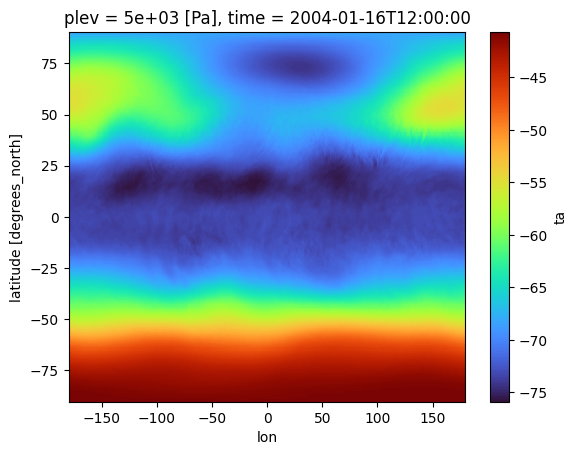

In [29]:
jan_2004_ta.to_netcdf(
    'export.nc'
)

jan_2004_ta.plot(
    cmap = 'turbo'
)

## Average Annual Near-Surface Air Temperature

In [47]:
ds = data_pipe.select_time_var()
ta_2004 = ds.sel(
    plev =5000 ,
    time = slice('2004-01-01', '2005-01-01')
)

# Convert to celsius
ta_2004 = (ta_2004 - 273.15)

# Fix my longitude [0, 360] --> [-180, 180]
ta_2004.coords['lon'] = (ta_2004.coords['lon'] + 180) % 360 - 180
ta_2004 = ta_2004.sortby(ta_2004.lon)

ta_2004 = ta_2004.compute()

ta_2004 = ta_2004.std(
    dim = ['time']
)

ta_2004

/usr/local/lib/python3.10/dist-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 12. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.DataArray 'ta' (lat: 361, lon: 720)>
array([[17.559944 , 17.559944 , 17.559944 , ..., 17.559944 , 17.559944 ,
        17.559944 ],
       [17.560165 , 17.560099 , 17.559923 , ..., 17.560585 , 17.560421 ,
        17.560383 ],
       [17.55652  , 17.55618  , 17.55607  , ..., 17.556875 , 17.556812 ,
        17.55656  ],
       ...,
       [ 9.999154 ,  9.99853  ,  9.997674 , ..., 10.001622 , 10.0008745,
        10.000069 ],
       [10.08634  , 10.085906 , 10.085594 , ..., 10.0871935, 10.087068 ,
        10.086744 ],
       [10.165145 , 10.165145 , 10.165145 , ..., 10.165145 , 10.165145 ,
        10.165145 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
    plev     float64 5e+03
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5

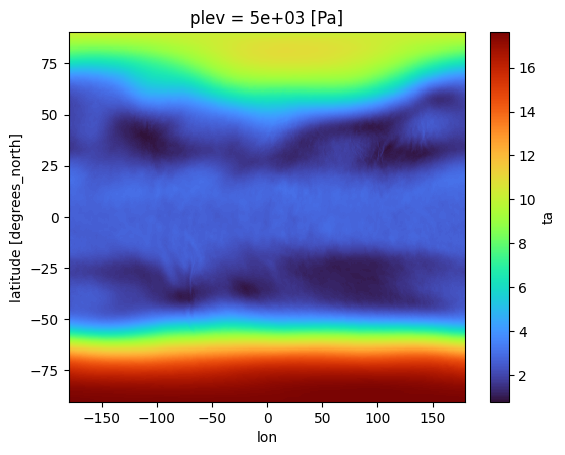

In [48]:
ta_2004.plot(
    cmap = 'turbo'
)

## 6-Hour Data for Air Temperature

In [53]:
ds = data_pipe.select_time_var(
    temporal_unit = '6hrPlevPt'
)
ta_2004 = ds.sel(
    plev =5000 ,
    time = slice('2004-01-01', '2005-01-01')
)
ta_2004

/usr/local/lib/python3.10/dist-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 12. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.DataArray 'ta' (time: 1468, lat: 361, lon: 720)>
dask.array<getitem, shape=(1468, 361, 720), dtype=float32, chunksize=(12, 361, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
    plev     float64 5e+03
  * time     (time) datetime64[ns] 2004-01-01 ... 2005-01-01T18:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: point
    comment:        Air Temperature
    long_name:      Air Temperature
    original_name:  t
    standard_name:  air_temperature
    units:          K